## 事前設定など…

In [50]:
%matplotlib inline

!pip install japanize-matplotlib -q
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

import re

from sklearn.model_selection import train_test_split

import lightgbm as lgb

import warnings
warnings.simplefilter("ignore")

pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",100)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## データの取得

In [3]:
import glob
train_pathes = glob.glob('/content/drive/MyDrive/Nishika2023秋/train/*')
for path in train_pathes:
    try:
        tmp_df = pd.read_csv(path)
        train_df = pd.concat([train_df,tmp_df])
    except:
        train_df = pd.read_csv(path)
train_df.reset_index(drop=True,inplace=True)

In [4]:
test_df = pd.read_csv("/content/drive/MyDrive/Nishika2023秋/test.csv")

## 前処理

In [33]:
def year_set(df):
    years = []
    for y in  df["建築年"]:
        tmp = re.sub("\\D", "", str(y))
        if "元年" in str(y) or (tmp.isdigit()):
            if "平成" in y:
                if y=="平成元年":
                    year = 1989
                else:
                    year = 1989 + int(re.sub("\\D", "", y)) - 1
            elif "昭和" in str(y):
                if y=="昭和元年":
                    year = 1926
                else:
                    year = 1926 + int(re.sub("\\D", "", y)) - 1
            elif "令和" in str(y):
                if y=="令和元年":
                    year = 2019
                else:
                    year = 2019 + int(re.sub("\\D", "", y)) - 1
        elif "戦前" in str(y):
            year=1940
        else:
            year=y
        years.append(year)
    print(years)
    return pd.Series(years)



def preprocessing(df):
    df = df.drop(columns=["地域","土地の形状","間口","延床面積（㎡）","前面道路：方位","前面道路：種類","前面道路：幅員（ｍ）"])
    df["最寄駅：距離（分）"] = df["最寄駅：距離（分）"].replace({"30分?60分":"45","1H?1H30":"75",'1H30?2H':"105","2H?":"120"})
    df["最寄駅：距離（分）"]=pd.to_numeric(df["最寄駅：距離（分）"], errors='coerce')
    df["面積（㎡）"] = df["面積（㎡）"].replace({"2000㎡以上":"2000"})
    df["面積（㎡）"] = pd.to_numeric(df["面積（㎡）"], errors='coerce')
    df["建築西暦年"] = year_set(df)

    df = pd.merge(df, pre_df, on='都道府県名')
    return df

pre_df = train_df.groupby("都道府県名").agg({"取引価格（総額）_log":["max","min","mean","std"]})
pre_df.columns = ['pre_max', 'pre_min', 'pre_mean', 'pre_std']

train_feats = preprocessing(train_df)
test_feats = preprocessing(test_df)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[2012, 1984, 1977, 1981, 1985, 1991, 1990, 2019, 2005, 2015, 1994, 1990, 1978, 1992, 1995, 2008, 2015, 1985, 2005, 1988, 2018, 1997, 2000, 1986, 1991, 1991, 2021, 2022, 1997, 2021, 2021, 2021, 2021, 2021, 1990, 2011, 1981, 1981, 1981, 1996, 1974, 1997, 2017, 1990, 1997, 1979, 2007, 1984, 1990, 2021, 2021, 2018, 1992, 1981, 1986, 2006, 2014, 1979, 2013, 2009, 2013, 1996, 2013, 2009, 2012, 2017, 1982, 1987, 1998, 1981, 1970, 1973, 1987, 2015, 1991, 1980, 1971, 2005, 2005, 2005, 2005, 2001, 2005, 2007, 1982, 1982, 1982, 2002, 2019, 1974, 1974, 1969, 2005, 2001, 2004, 2004, 1974, 1974, 1974, 1997, 1988, 1974, 1974, 1989, 1985, 1985, 1974, 1971, 1971, 2007, 1971, 1981, 1974, 1996, 2010, 1984, 1973, 1973, 1981, 2016, 2007, 2016, 1980, 1989, 1996, 1989, 2019, 1990, 1990, 1998, 2000, 1984, 1984, 2003, 2009, 2018, 2013, 2001, 1986, 1988, 2001, 2008, 1982, 1982, 1998, 1987, 2003, 2003, 1987, 1964, 1991, 1999, 1992, 1992, 1974, 1974, 1974, 1983, 2019, 1990, 1990, 1995, 1977, 1977, 2004, 1997, 198

## データの確認

In [48]:
train_feats.head(1)

,ID,種類,市区町村コード,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,建物の構造,用途,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等,取引価格（総額）_log,建築西暦年,pre_max,pre_min,pre_mean,pre_std
0,32001113,中古マンション等,32201,島根県,松江市,砂子町,松江,45.0,３ＬＤＫ,90,平成31年,ＲＣ,住宅,住宅,第２種中高層住居専用地域,60.0,200.0,2021年第4四半期,未改装,NaN,7.50515,2019.0,7.556303,5.875061,7.187249,0.179285


In [9]:
train_feats.describe()

,ID,市区町村コード,最寄駅：距離（分）,面積（㎡）,建ぺい率（％）,容積率（％）,取引価格（総額）_log,建築西暦年
count,7.933770e+05,793377.000000,770138.000000,793377.000000,767800.000000,767800.000000,793377.000000,770174.000000
mean,1.852902e+07,18538.555123,11.612168,58.305446,67.737210,303.455626,7.236956,1995.650415
std,9.557994e+06,9590.061293,12.161787,27.020574,10.420672,148.600044,0.357088,11.899154
min,1.000008e+06,1101.000000,0.000000,10.000000,30.000000,50.000000,2.653213,1940.000000
25%,1.308704e+07,13107.000000,5.000000,45.000000,60.000000,200.000000,7.041393,1988.000000
50%,1.403721e+07,14104.000000,8.000000,65.000000,60.000000,200.000000,7.278754,1997.000000
75%,2.704183e+07,27115.000000,14.000000,75.000000,80.000000,400.000000,7.477121,2005.000000
max,4.703861e+07,47213.000000,120.000000,2000.000000,80.000000,1300.000000,9.934498,2023.000000


In [10]:
train_feats.isnull().sum()

ID                   0
種類                   0
市区町村コード              0
都道府県名                0
市区町村名                0
地区名                675
最寄駅：名称            2813
最寄駅：距離（分）        23239
間取り              30067
面積（㎡）                0
建築年              23203
建物の構造            23033
用途               89206
今後の利用目的         368668
都市計画             20872
建ぺい率（％）          25577
容積率（％）           25577
取引時点                 0
改装               78647
取引の事情等          773893
取引価格（総額）_log         0
建築西暦年            23203
dtype: int64

In [54]:
train_feats.groupby("取引時点").agg({"取引価格（総額）_log":["max","min","mean","std"]})

取引価格（総額）_log                              
                    max       min      mean       std
取引時点                                                 
2005年第3四半期     9.113943  5.531479  7.228577  0.303857
2005年第4四半期     8.623249  5.518514  7.246956  0.303427
2006年第1四半期     8.812913  5.770852  7.273262  0.317456
2006年第2四半期     8.662758  5.698970  7.181304  0.316870
2006年第3四半期     9.414973  5.602060  7.198315  0.329240
2006年第4四半期     8.544068  5.176091  7.201533  0.324677
2007年第1四半期     8.857332  5.740363  7.227999  0.324160
2007年第2四半期     8.959041  5.301030  7.183082  0.322446
2007年第3四半期     9.041393  5.000000  7.182052  0.329806
2007年第4四半期     8.748188  4.698970  7.188803  0.335659
2008年第1四半期     9.176091  5.633468  7.214204  0.340370
2008年第2四半期     8.681241  2.991226  7.190022  0.351528
2008年第3四半期     9.447158  3.230449  7.190341  0.345984
2008年第4四半期     8.602060  5.477121  7.178147  0.343748
2009年第1四半期     8.653213  5.361728  7.203506  0.346974
2009年第2四半期     8.954243  4.698970  7.185145  0.349540
2009年第3四半期     9.278754  4.698970  7.194045  0.351652
2009年第4四半期     8.806180  3.361728  7.185118  0.351074
2010年第1四半期     8.819544  5.041393  7.204513  0.353624
2010年第2四半期     9.113943  2.977724  7.178423  0.367002
2010年第3四半期     8.826075  3.934498  7.202604  0.362857
2010年第4四半期     8.913814  3.079181  7.193275  0.369014
2011年第1四半期     9.462398  3.079181  7.219076  0.360827
2011年第2四半期     8.806180  5.447158  7.168975  0.352991
2011年第3四半期     8.491362  3.000000  7.176122  0.356701
2011年第4四半期     8.568202  3.000000  7.165957  0.362247
2012年第1四半期     8.491362  4.698970  7.180932  0.358398
2012年第2四半期     8.602060  3.000000  7.167574  0.353579
2012年第3四半期     8.963788  2.991226  7.172630  0.353009
2012年第4四半期     9.041393  2.724276  7.164382  0.369643
2013年第1四半期     8.602060  5.397940  7.184924  0.353326
2013年第2四半期     9.301030  3.000000  7.188413  0.359233
2013年第3四半期     8.954243  5.301030  7.189326  0.358354
2013年第4四半期     8.643453  3.000000  7.179454  0.360401
2014年第1四半期     9.079181  2.845098  7.209725  0.350447
2014年第2四半期     8.556303  2.653213  7.189276  0.359496
2014年第3四半期     9.041393  5.000000  7.201904  0.353814
2014年第4四半期     9.113943  3.000000  7.204751  0.357171
2015年第1四半期     9.230449  5.397940  7.234939  0.346107
2015年第2四半期     8.556303  5.397940  7.218361  0.351491
2015年第3四半期     9.505150  3.000000  7.228566  0.354654
2015年第4四半期     8.556303  3.000000  7.221028  0.351664
2016年第1四半期     8.799341  4.301030  7.236353  0.363695
2016年第2四半期     8.875061  4.698970  7.234769  0.353928
2016年第3四半期     8.518514  5.397940  7.251792  0.350449
2016年第4四半期     9.934498  4.477121  7.244300  0.360159
2017年第1四半期     9.146128  4.000000  7.258410  0.362576
2017年第2四半期     8.826075  4.477121  7.252054  0.352638
2017年第3四半期     8.681241  5.146128  7.261904  0.351870
2017年第4四半期     8.897627  5.000000  7.254829  0.354377
2018年第1四半期     9.079181  4.000000  7.278960  0.347733
2018年第2四半期     9.113943  5.000000  7.271348  0.350318
2018年第3四半期     9.079181  4.176091  7.271202  0.354788
2018年第4四半期     9.176091  4.792392  7.271745  0.347100
2019年第1四半期     8.643453  5.255273  7.291576  0.346025
2019年第2四半期     8.903090  4.778151  7.282692  0.353664
2019年第3四半期     9.278754  4.000000  7.287150  0.359148
2019年第4四半期     8.778151  4.826075  7.287181  0.358784
2020年第1四半期     9.462398  5.000000  7.307216  0.353560
2020年第2四半期     8.740363  5.000000  7.282933  0.357394
2020年第3四半期     9.113943  3.000000  7.309506  0.352286
2020年第4四半期     8.748188  4.301030  7.302852  0.358716
2021年第1四半期     8.792392  5.000000  7.318674  0.361176
2021年第2四半期     9.397940  5.000000  7.315803  0.352558
2021年第3四半期     8.763428  5.000000  7.322744  0.356158
2021年第4四半期     9.204120  4.000000  7.319773  0.365156
2022年第1四半期     9.041393  4.477121  7.334358  0.359128
2022年第2四半期     8.698970  4.000000  7.332856  0.357442
2022年第3四半期     8.944483  3.000000  7.331337  0.368406

## 学習

In [42]:
TARGET = "取引価格（総額）_log"
columns = ["ID","種類","市区町村コード","都道府県名","市区町村名","地区名","最寄駅：名称","間取り","建築年",
           "建物の構造","用途","今後の利用目的","都市計画","取引時点","改装","取引の事情等"]

X = train_feats.drop(columns,axis=1).drop(TARGET,axis=1)
y = train_feats[TARGET]

tra_X,val_X,tra_y,val_y = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=0)

In [44]:
lgb_params = {
        'objective':'regression',
        'metric': 'rmse',
        'seed': 42,
        'n_estimators':20000,
        }

model = lgb.LGBMRegressor(**lgb_params)
model.fit(tra_X,
              tra_y,
              eval_set=[(val_X, val_y)],
              callbacks=[
                    lgb.early_stopping(stopping_rounds=1, verbose=True),
                lgb.log_evaluation(100),],
              )

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 377
[LightGBM] [Info] Number of data points in the train set: 634701, number of used features: 9
[LightGBM] [Info] Start training from score 7.237151
Training until validation scores don't improve for 1 rounds
[100]	valid_0's rmse: 0.18365
Early stopping, best iteration is:
[161]	valid_0's rmse: 0.182453


LGBMRegressor(metric='rmse', n_estimators=20000, objective='regression',
              seed=42)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

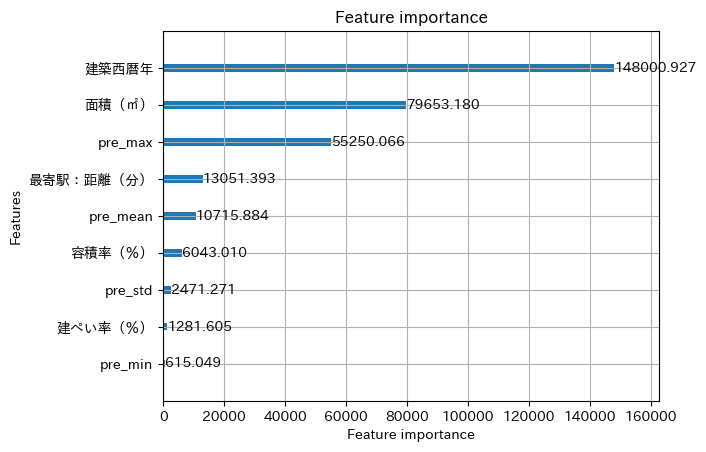

In [45]:
lgb.plot_importance(model, importance_type='gain')

## 予測

In [47]:
sub = pd.read_csv("/content/drive/MyDrive/Nishika2023秋/sample_submission.csv")
sub[TARGET] = model.predict(test_feats.drop(columns,axis=1))
sub.to_csv("/content/drive/MyDrive/Nishika2023秋/submission.csv",index=False)